In [2]:
import torch
from torch import nn, optim
from torch.fft import Tensor
from torch.utils.data import DataLoader

import os
import requests
import zipfile
from pathlib import Path

import torchvision
from torchvision.transforms import v2
from torchvision import datasets, transforms

from PIL import Image
import random

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

from helper_functions import *
from tqdm.auto import tqdm


print(torch.__version__)

2.5.1


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1 Get Data

Our datasets is smaller compared to the Food101, Only 10 percent of original and 3 classes.



In [4]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print("Image folder exists")
else:
    print("Image folder does not exist")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download Data

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Extracting zip file")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
   zip_ref.extractall(image_path)

Image folder exists
Extracting zip file


# 2. Data Prep and Exploration

In [5]:
import os
def walk_through_dir(dir_path):
    """ Walk through a directory and yield all files in that directory """
    for root, dirs, files in os.walk(dir_path):
        print(f"Found {len(files)} files in {root} and {len(dirs)} directories in {root}")

In [6]:
walk_through_dir(image_path)

Found 0 files in data\pizza_steak_sushi and 2 directories in data\pizza_steak_sushi
Found 0 files in data\pizza_steak_sushi\test and 3 directories in data\pizza_steak_sushi\test
Found 25 files in data\pizza_steak_sushi\test\pizza and 0 directories in data\pizza_steak_sushi\test\pizza
Found 19 files in data\pizza_steak_sushi\test\steak and 0 directories in data\pizza_steak_sushi\test\steak
Found 31 files in data\pizza_steak_sushi\test\sushi and 0 directories in data\pizza_steak_sushi\test\sushi
Found 0 files in data\pizza_steak_sushi\train and 3 directories in data\pizza_steak_sushi\train
Found 78 files in data\pizza_steak_sushi\train\pizza and 0 directories in data\pizza_steak_sushi\train\pizza
Found 75 files in data\pizza_steak_sushi\train\steak and 0 directories in data\pizza_steak_sushi\train\steak
Found 72 files in data\pizza_steak_sushi\train\sushi and 0 directories in data\pizza_steak_sushi\train\sushi


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

# 2.1 Visualing and image

1. Get all image paths
2. Pick a random image using random.choice
3. Get Parent folder name
4. Open Image using PIL(Pillow)
5. Show image and print metadata


data\pizza_steak_sushi\train\sushi\2980779.jpg
sushi
Image size: (512, 512)
Image Height: 512
Image Width: 512
Image Class: sushi


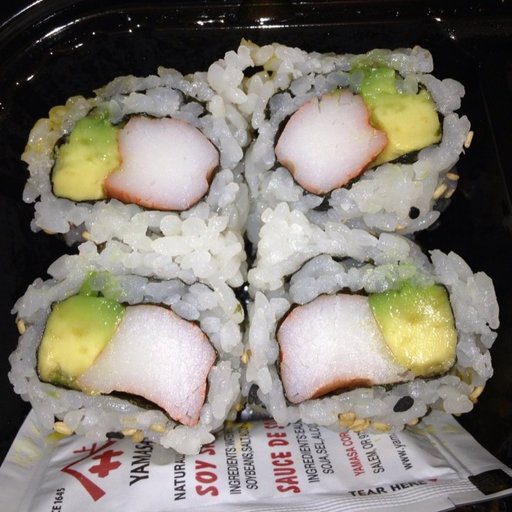

In [8]:
# random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image
random_image = random.choice(image_path_list)
print(random_image)
#Get Image Class, Name of class

image_class = random_image.parent.stem
print(image_class)

# Open Image
img = Image.open(random_image)


print(f"Image size: {img.size}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
print(f"Image Class: {image_class}")
img

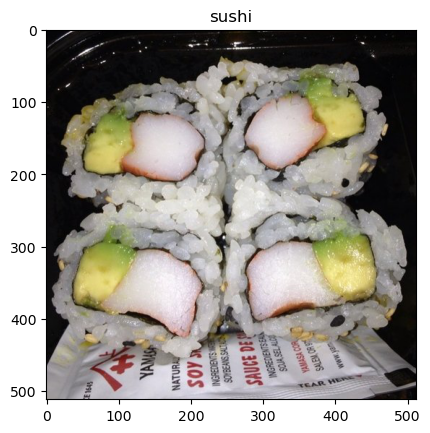

In [9]:
# Viewing Image using matplollib

imgage = mpimg.imread(random_image)
plt.imshow(imgage)
plt.title(image_class)
plt.show()

# 3. Transforming Data for Pytorch

1. Turn Target Data in tensors
2. Turn it into a 'torch.utils.datasets' and then in 'torch.utils.data.dataloader'


3.1 Transforming data

In [10]:
data_transform = v2.Compose([

    v2.ToImage(),

    v2.Resize(size=(64, 64)),

    # v2.RandomHorizontalFlip(p=0.5),

    v2.ToDtype(dtype=torch.float32, scale=True),

    # v2.AutoAugment(),

    v2.ToPureTensor()
])

# print(img)
# data_transform[img]

In [11]:
im = data_transform(img)
im

tensor([[[0.0235, 0.0235, 0.0549,  ..., 0.0196, 0.0314, 0.0314],
         [0.0275, 0.0627, 0.1608,  ..., 0.0196, 0.0196, 0.0196],
         [0.0824, 0.1020, 0.0902,  ..., 0.0392, 0.0392, 0.0431],
         ...,
         [0.6275, 0.6235, 0.6078,  ..., 0.1765, 0.2745, 0.3098],
         [0.6275, 0.6196, 0.6000,  ..., 0.1961, 0.1412, 0.0706],
         [0.6196, 0.6196, 0.6078,  ..., 0.0902, 0.0745, 0.0314]],

        [[0.0235, 0.0235, 0.0471,  ..., 0.0157, 0.0235, 0.0235],
         [0.0275, 0.0627, 0.1569,  ..., 0.0196, 0.0196, 0.0196],
         [0.0745, 0.0941, 0.0824,  ..., 0.0353, 0.0392, 0.0392],
         ...,
         [0.6078, 0.6039, 0.5922,  ..., 0.1647, 0.2510, 0.2902],
         [0.6118, 0.6039, 0.5882,  ..., 0.1804, 0.1216, 0.0627],
         [0.6039, 0.6039, 0.5961,  ..., 0.0588, 0.0510, 0.0314]],

        [[0.0314, 0.0353, 0.0627,  ..., 0.0235, 0.0314, 0.0275],
         [0.0353, 0.0745, 0.1804,  ..., 0.0196, 0.0196, 0.0196],
         [0.0824, 0.1020, 0.0863,  ..., 0.0275, 0.0314, 0.

In [12]:
import numpy as np

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    # if seed:
    torch.manual_seed(seed)
    random_image_path = random.sample(image_paths, n)
    for image_path in random_image_path:
            f = Image.open(image_path)

            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(image_path.parent.stem)
            ax[0].axis('off')

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(image_path.parent.stem)
            ax[1].axis('off')

            fig.suptitle(image_path.parent.stem)

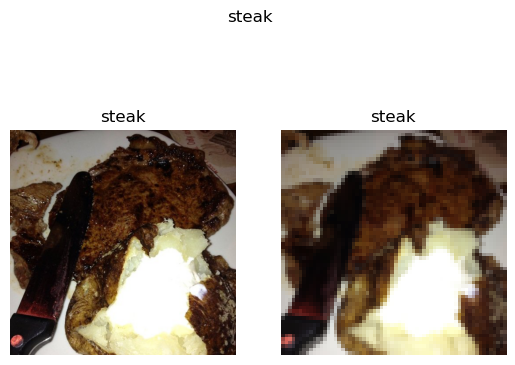

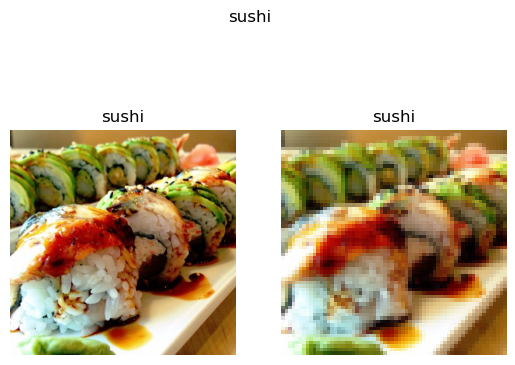

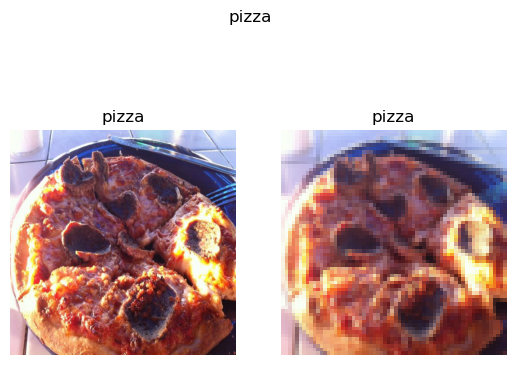

In [13]:
plot_transformed_images(image_path_list, data_transform, )

# 4. Option 1: Loading image data using ImageFolder

In [14]:
from torchvision import datasets
# train_data = datasets.ImageFolder(root=train_dir,
#                                   transform=data_transform, # Transform to convert images from data
#                                   target_transform=None)    # A transform for thr label/target
#
# test_data = datasets.ImageFolder(root=test_dir,
#                                  transform=data_transform,
#                                  target_transform=None)
#
# train_data, test_data

In [15]:
# train_data.class_to_idx

In [16]:
# len(train_data), len(test_data)

In [17]:
# img, label = train_data[0][0], train_data[0][1]
#
# print(f'Image tensor {img}')
# print(f'Image Shape {img.shape}')
# print(f'Image dtype {img.dtype}')
# print(f'Image label {label}')
# print(f'Label dtype {type(label)}')


In [18]:
# img_permute = img.permute(1, 2, 0)
# plt.figure(figsize=(10, 7))
# plt.imshow(img_permute)
# plt.axis('off')
# plt.show()
#


In [19]:
# BATCH_SIZE = 32
#
# train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)

In [20]:
# len(train_dataloader), len(test_dataloader)

# First model with augmentation,

In [21]:
class ImageClassv0(nn.Module):
    def __init__(self, input, output, hidden):
        super(ImageClassv0, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input, out_channels=hidden, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*13*13, out_features=output),
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x


# model0 = ImageClassv0(input=3, output=3, hidden=32)
# model0.to(device)
# model0

ImageClassv0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5408, out_features=3, bias=True)
  )
)

In [22]:
# rand_tensor = torch.rand(1,3,64,64)
# model0(rand_tensor)

In [23]:
# image_b, label_b = next(iter(train_dataloader))
# image_b.shape, label_b.shape
# model0(image_b.to(device))

# USE torchinfo to get idea on shapes which go through our model

In [24]:
# from torchinfo import summary
#
# summary(model0, input_size=[32, 3, 64, 64])

In [25]:
# Creating Loops train and test step

def train_step(model, data_loader, loss_fn, optimizer):

    model.train() # Training Model

    train_loss = 0
    train_acc = 0

    for batch, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)

        y_pred = model(x)

        loss = loss_fn(y_pred, y)

        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_acc += accuracy_fn(torch.argmax(torch.softmax(y_pred, dim=1), dim=1), y)

        # if (batch + 1) % 2 == 0:
        #     print(f"Batch: {batch + 1}/{len(data_loader)}")

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"TRAIN: Loss: {train_loss}, Accuracy: {train_acc}")

# Creating Loops train and test step

def test_step(model, data_loader, loss_fn):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():


        for batch, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            test_loss += loss.item()

            # optimizer.zero_grad()

            # loss.backward()

            # optimizer.step()

            test_acc += accuracy_fn(torch.argmax(torch.softmax(y_pred, dim=1), dim=1), y)

            # if (batch + 1) % 2 == 0:
            #     print(f"Batch: {batch + 1}/{len(data_loader)}")

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"TEST: Loss: {test_loss}, Accuracy: {test_acc}")


In [26]:
# epochs = 10
#
# for epoch in tqdm(range(epochs)):
#
#     print(f"Epoch {epoch+1}/{epochs}")
#
#     train_step(model=model0, data_loader=train_dataloader, loss_fn=nn.CrossEntropyLoss(), optimizer=optim.Adam(model0.parameters(), lr=0.001))
#
#     test_step(model=model0, data_loader=test_dataloader, loss_fn=nn.CrossEntropyLoss(), optimizer=optim.Adam(model0.parameters(), lr=0.001))

In [27]:
transform_aug = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(64, 64)),

    # v2.TrivialAugmentWide(num_magnitude_bins=31),
    v2.ToDtype(dtype=torch.float32, scale=True),

    v2.ToPureTensor()
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(64, 64)),
    v2.ToDtype(dtype=torch.float32, scale=True),

    v2.ToPureTensor()

])

In [28]:
train_data_augmented = datasets.ImageFolder(root=train_dir, transform=transform_aug, target_transform=None)


test_data_augmented = datasets.ImageFolder(root=test_dir, transform=test_transform, target_transform=None)
train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToDtype(scale=True)
                  ToPureTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToDtype(scale=True)
                  ToPureTensor()
            ))

In [29]:
BATCH_SIZE = 32

NUM_WORKERS = 6

train_dataloader = DataLoader(train_data_augmented, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

test_dataloader = DataLoader(test_data_augmented, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

In [32]:
# New model with augmented
model1 = ImageClassv0(input=3, output=3, hidden=64)
model1

epochs = 10


In [33]:
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch + 1}/{epochs}")

    train_step(model=model1, data_loader=train_dataloader, loss_fn=nn.CrossEntropyLoss(),
               optimizer=optim.Adam(model1.parameters(), lr=0.001))

    test_step(model=model1, data_loader=test_dataloader, loss_fn=nn.CrossEntropyLoss())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
TRAIN: Loss: 1.114398792386055, Accuracy: 32.8125
TEST: Loss: 1.092982252438863, Accuracy: 37.121212121212125
Epoch 2/10
TRAIN: Loss: 1.0648287236690521, Accuracy: 35.9375
TEST: Loss: 0.9897357026735941, Accuracy: 51.42045454545454
Epoch 3/10
TRAIN: Loss: 1.0715432837605476, Accuracy: 42.96875
TEST: Loss: 1.0154753923416138, Accuracy: 45.45454545454546
Epoch 4/10
TRAIN: Loss: 0.9953526183962822, Accuracy: 42.96875
TEST: Loss: 1.0309700568517048, Accuracy: 41.38257575757576
Epoch 5/10
TRAIN: Loss: 0.9120653420686722, Accuracy: 65.234375
TEST: Loss: 1.0188523332277934, Accuracy: 48.29545454545454
Epoch 6/10
TRAIN: Loss: 0.9560704380273819, Accuracy: 52.34375
TEST: Loss: 0.9654702941576639, Accuracy: 49.33712121212121
Epoch 7/10
TRAIN: Loss: 0.8012117296457291, Accuracy: 67.96875
TEST: Loss: 1.032207727432251, Accuracy: 47.348484848484844
Epoch 8/10
TRAIN: Loss: 0.7372363470494747, Accuracy: 67.1875
TEST: Loss: 1.0166805585225422, Accuracy: 47.253787878787875
Epoch 9/10
TRAIN: 